## 1. Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

## 2. Import Dependencies and Load Data

In [397]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Load data from following files ::
1. Train data :: train.csv. Contains both dependent and independent features. So for model creation we will create train and test data from this file.
2. Test or unseen data :: test.csv. Contains only independent variables. Will use our model to predict the solution using this unseen data.
3. Data Dictionary :: data_dictionary

In [398]:
data = pd.read_csv("train.csv")
unseen_data = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")
sample = pd.read_csv("sample.csv")

In [399]:
data.shape

(69999, 172)

In [400]:
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0              6/30/14              7/31/14              8/31/14   31.277   
1              6/30/14              7/31/14              8/31/14    0.000   
2              6/30/14              7/31/14              8/31/14   60.806   
3              6/30/14              7/31/14              8/31/14  156.362   
4              6/30/14              7/31/14              8/31/14  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [401]:
data_dict.head()

Acronyms                                        Description
0  CIRCLE_ID  Telecom circle area to which the customer belo...
1        LOC            Local calls  within same telecom circle
2        STD              STD calls  outside the calling circle
3         IC                                     Incoming calls
4         OG                                     Outgoing calls

In [402]:
### Checking the Churn Rate
churn = (sum(data['churn_probability'])/len(data['churn_probability'].index))*100
churn

10.188716981671167

There are multiple acronyms have been used in the dataset. Using regular expressions to filter important columns from the dataset.

In [403]:
average_revenue = [i for i in list(data.columns) if re.search('arpu_[678]',i)]
onnet_monthly_usage = [i for i in list(data.columns) if re.search('onnet_mou_[678]',i)]
offnet_monthly_usage = [i for i in list(data.columns) if re.search('offnet_mou_[678]',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
total_recharge_number = [i for i in list(data.columns) if re.search('total.+rech.+num_[678]',i)]
total_recharge_amount = [i for i in list(data.columns) if re.search('total.+rech.+amt_[678]',i)]
max_recharge_amount = [i for i in list(data.columns) if re.search('max.+rech.+amt_[678]',i)]
total_recharge_data = [i for i in list(data.columns) if re.search('total.+rech.+data[678]',i)]
max_recharge_data = [i for i in list(data.columns) if re.search('max.+rech.+data[678]',i)]
volume_of_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_of_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
social_user = [i for i in list(data.columns) if re.search('fb.+user',i)]

ids = ['id','circle_id']

# Creating new variable with all the columns
columns = [*ids, *average_revenue, *onnet_monthly_usage, *offnet_monthly_usage, *total_outgoing_minutes,
          *total_incoming_minutes, *total_recharge_number, *total_recharge_amount, *max_recharge_amount, *total_recharge_data,
          *max_recharge_data, *volume_of_3g, *volume_of_2g, *age_on_network, *social_user, 'churn_probability']


In [404]:
# Select only above columns in the working dataset
data = data[columns]

In [405]:
data.head()
data.shape

(69999, 37)

We have selected intial 37 colummns to work with. Now check the datatypes of each column.

In [406]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 69999 non-null  int64  
 1   circle_id          69999 non-null  int64  
 2   arpu_6             69999 non-null  float64
 3   arpu_7             69999 non-null  float64
 4   arpu_8             69999 non-null  float64
 5   onnet_mou_6        67231 non-null  float64
 6   onnet_mou_7        67312 non-null  float64
 7   onnet_mou_8        66296 non-null  float64
 8   offnet_mou_6       67231 non-null  float64
 9   offnet_mou_7       67312 non-null  float64
 10  offnet_mou_8       66296 non-null  float64
 11  total_og_mou_6     69999 non-null  float64
 12  total_og_mou_7     69999 non-null  float64
 13  total_og_mou_8     69999 non-null  float64
 14  total_ic_mou_6     69999 non-null  float64
 15  total_ic_mou_7     69999 non-null  float64
 16  total_ic_mou_8     699

We can see all variables are of numeric type. Now check the null values :: 

In [407]:
# Checking the percentage of missing values
round(100*(data.isnull().sum()/len(data.index)), 2)

id                    0.00
circle_id             0.00
arpu_6                0.00
arpu_7                0.00
arpu_8                0.00
onnet_mou_6           3.95
onnet_mou_7           3.84
onnet_mou_8           5.29
offnet_mou_6          3.95
offnet_mou_7          3.84
offnet_mou_8          5.29
total_og_mou_6        0.00
total_og_mou_7        0.00
total_og_mou_8        0.00
total_ic_mou_6        0.00
total_ic_mou_7        0.00
total_ic_mou_8        0.00
total_rech_num_6      0.00
total_rech_num_7      0.00
total_rech_num_8      0.00
total_rech_amt_6      0.00
total_rech_amt_7      0.00
total_rech_amt_8      0.00
max_rech_amt_6        0.00
max_rech_amt_7        0.00
max_rech_amt_8        0.00
vol_3g_mb_6           0.00
vol_3g_mb_7           0.00
vol_3g_mb_8           0.00
vol_2g_mb_6           0.00
vol_2g_mb_7           0.00
vol_2g_mb_8           0.00
aon                   0.00
fb_user_6            74.90
fb_user_7            74.48
fb_user_8            73.69
churn_probability     0.00
d

Significant percentages of fb_user_6, fb_user_7 and fb_user_8 are null. Dropping these columns.

In [408]:
## Dropping columns with higher null values
data = data.drop(['fb_user_6','fb_user_7','fb_user_8'], axis=1)

In [409]:
## Checking values in circle_id column
data["circle_id"].value_counts()

circle_id
109    69999
Name: count, dtype: int64

In [410]:
### As circle_id only contains, dropping it
data = data.drop(['circle_id'], axis=1)

In [411]:
data.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  max_rech_amt_7  \
0         32.24         96.68          2.33  ...              65   
1          0.00         25.99         30.89  ...             145   
2         53.99         82.05          0.00  ...              70   
3         68.76         78.48         50.23  ...             110   
4         56.99         38.11          9.63  ...              41   

   max_rech_amt_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  \
0              10          0.0         0.00          0.0          0.0   
1              50          0.0         3.96          0.0          0.0   
2               0          0.0         0.00          0.0          0.0   
3              50          0.0         0.00          0.0          0.0   
4              30          0.0         0.00          0.0        390.8   

   vol_2g_mb_7  vol_2g_mb_8   aon  churn_probability  
0         0.00         0.00  1958                  0  
1       352.91         0.00   710                  0  
2         0.00         0.00   882                  0  
3         0.00         0.00   982                  0  
4       308.89       213.47   647                  0  

[5 rows x 33 columns]

In [412]:
## checking null values again
round(100*(data.isnull().sum()/len(data.index)), 2)

id                   0.00
arpu_6               0.00
arpu_7               0.00
arpu_8               0.00
onnet_mou_6          3.95
onnet_mou_7          3.84
onnet_mou_8          5.29
offnet_mou_6         3.95
offnet_mou_7         3.84
offnet_mou_8         5.29
total_og_mou_6       0.00
total_og_mou_7       0.00
total_og_mou_8       0.00
total_ic_mou_6       0.00
total_ic_mou_7       0.00
total_ic_mou_8       0.00
total_rech_num_6     0.00
total_rech_num_7     0.00
total_rech_num_8     0.00
total_rech_amt_6     0.00
total_rech_amt_7     0.00
total_rech_amt_8     0.00
max_rech_amt_6       0.00
max_rech_amt_7       0.00
max_rech_amt_8       0.00
vol_3g_mb_6          0.00
vol_3g_mb_7          0.00
vol_3g_mb_8          0.00
vol_2g_mb_6          0.00
vol_2g_mb_7          0.00
vol_2g_mb_8          0.00
aon                  0.00
churn_probability    0.00
dtype: float64

Still very small percentage of on-netwok and off-network minutes of usage columns are null. We will have to impute values for those. Here we will use constant '0' value to impute. 

In [413]:
## Extract the missing columns
missing_data_percent = data.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8'],
      dtype='object')

In [414]:
## Use SimpleImputer with constant strategy
imp = SimpleImputer(strategy='constant', fill_value=0)
data[impute_cols] = imp.fit_transform(data[impute_cols])

In [415]:
## checking null values again
round(100*(data.isnull().sum()/len(data.index)), 2)

id                   0.0
arpu_6               0.0
arpu_7               0.0
arpu_8               0.0
onnet_mou_6          0.0
onnet_mou_7          0.0
onnet_mou_8          0.0
offnet_mou_6         0.0
offnet_mou_7         0.0
offnet_mou_8         0.0
total_og_mou_6       0.0
total_og_mou_7       0.0
total_og_mou_8       0.0
total_ic_mou_6       0.0
total_ic_mou_7       0.0
total_ic_mou_8       0.0
total_rech_num_6     0.0
total_rech_num_7     0.0
total_rech_num_8     0.0
total_rech_amt_6     0.0
total_rech_amt_7     0.0
total_rech_amt_8     0.0
max_rech_amt_6       0.0
max_rech_amt_7       0.0
max_rech_amt_8       0.0
vol_3g_mb_6          0.0
vol_3g_mb_7          0.0
vol_3g_mb_8          0.0
vol_2g_mb_6          0.0
vol_2g_mb_7          0.0
vol_2g_mb_8          0.0
aon                  0.0
churn_probability    0.0
dtype: float64

In [416]:
data.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  max_rech_amt_7  \
0         32.24         96.68          2.33  ...              65   
1          0.00         25.99         30.89  ...             145   
2         53.99         82.05          0.00  ...              70   
3         68.76         78.48         50.23  ...             110   
4         56.99         38.11          9.63  ...              41   

   max_rech_amt_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  \
0              10          0.0         0.00          0.0          0.0   
1              50          0.0         3.96          0.0          0.0   
2               0          0.0         0.00          0.0          0.0   
3              50          0.0         0.00          0.0          0.0   
4              30          0.0         0.00          0.0        390.8   

   vol_2g_mb_7  vol_2g_mb_8   aon  churn_probability  
0         0.00         0.00  1958                  0  
1       352.91         0.00   710                  0  
2         0.00         0.00   882                  0  
3         0.00         0.00   982                  0  
4       308.89       213.47   647                  0  

[5 rows x 33 columns]

Now we do not have any missing values.

Now we will check the details of data in the selected columns. And based on that we will decide to remove outliers.

In [417]:
data.describe()

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean   34999.000000    283.134365    278.185912    278.858826    127.887939   
std    20207.115084    334.213918    344.366927    351.924315    295.115497   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17499.500000     93.581000     86.714000     84.095000      5.430000   
50%    34999.000000    197.484000    191.588000    192.234000     30.830000   
75%    52498.500000    370.791000    365.369500    369.909000    113.100000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     128.754731    125.943607    191.010582    189.585401    186.146273   
std      306.326345    304.990552    312.900706    318.492632    318.453812   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.910000      4.110000     28.790000     26.690000     23.780000   
50%       29.160000     27.840000     89.810000     85.590000     83.010000   
75%      108.940000    106.280000    223.540000    218.350000    216.410000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       ...  max_rech_amt_7  max_rech_amt_8   vol_3g_mb_6   vol_3g_mb_7  \
count  ...    69999.000000    69999.000000  69999.000000  69999.000000   
mean   ...      104.137573      107.540351    122.171882    128.934444   
std    ...      120.782543      124.396750    554.869965    554.096072   
min    ...        0.000000        0.000000      0.000000      0.000000   
25%    ...       30.000000       30.000000      0.000000      0.000000   
50%    ...      110.000000       98.000000      0.000000      0.000000   
75%    ...      128.000000      144.000000      0.000000      0.000000   
max    ...     3299.000000     4449.000000  45735.400000  28144.120000   

        vol_3g_mb_8   vol_2g_mb_6   vol_2g_mb_7   vol_2g_mb_8           aon  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     135.486541     51.773924     51.240204     50.127506   1220.639709   
std      568.310234    212.513909    211.114667    213.101403    952.426321   
min        0.000000      0.000000      0.000000      0.000000    180.000000   
25%        0.000000      0.000000      0.000000      0.000000    468.000000   
50%        0.000000      0.000000      0.000000      0.000000    868.000000   
75%        0.000000      0.000000      0.000000      0.000000   1813.000000   
max    30036.060000  10285.900000   7873.550000  11117.610000   4337.000000   

       churn_probability  
count       69999.000000  
mean            0.101887  
std             0.302502  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             1.000000  

[8 rows x 33 columns]

Seeing there are outliers for multiple columns. Applying IQR method to remove outliers and keep data between 5th and 95th percentiles.

In [418]:
## Remove outliers using IQR - removing  
def iqr_outliers_flag(s):
    q1, q3 = np.quantile(s, [0.05, 0.95])
    iqr = q3 - q1
    upper_bound = q1 + 1.5 * iqr
    lower_bound = q3 - 1.5 * iqr
    
    return (s <= lower_bound) | (s >= upper_bound)

data_filtered = data[~data.apply(iqr_outliers_flag).any(axis=1)]
data_filtered.shape

(52289, 33)

In [419]:
## Checking the churn rate
churn = (sum(data_filtered['churn_probability'])/len(data_filtered['churn_probability'].index))*100
churn

10.506989997896307

We have removed major null columns and impute data with low null/missing values. Have treated outliers also. All the columns are of numeric type. We have only 10% churn rate. So data is highly imbalanced and this will be a significant factor while building model.

Definition of "high-value" customer has not given. So creating a new derived column "total_arpu" (Total Average Revenue Per User) by summation of columns "arpu_6", "arpu_7" and "arpu_8"

In [420]:
data_filtered['total_arpu'] = data_filtered.apply(lambda row: row['arpu_6'] + row['arpu_7'] + row['arpu_8'], axis=1)

In [421]:
data_filtered.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  max_rech_amt_8  vol_3g_mb_6  \
0         32.24         96.68          2.33  ...              10          0.0   
1          0.00         25.99         30.89  ...              50          0.0   
2         53.99         82.05          0.00  ...               0          0.0   
3         68.76         78.48         50.23  ...              50          0.0   
4         56.99         38.11          9.63  ...              30          0.0   

   vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8   aon  \
0         0.00          0.0          0.0         0.00         0.00  1958   
1         3.96          0.0          0.0       352.91         0.00   710   
2         0.00          0.0          0.0         0.00         0.00   882   
3         0.00          0.0          0.0         0.00         0.00   982   
4         0.00          0.0        390.8       308.89       213.47   647   

   churn_probability  total_arpu  
0                  0     125.813  
1                  0     165.740  
2                  0     163.982  
3                  0     472.717  
4                  0     470.464  

[5 rows x 34 columns]

In [422]:
## Check the mean of "total_arpu" column
data_filtered["total_arpu"].mean()

595.8118963835606

In [423]:
## Assuming high-value customer has arpu >= ~500
data_filtered_high_value = data_filtered[ data_filtered["total_arpu"] > 500 ]

In [424]:
## high-value customer shape
data_filtered_high_value.shape

(25000, 34)

In [425]:
## Checking the churn rate for high-value customer
churn = (sum(data_filtered_high_value['churn_probability'])/len(data_filtered_high_value['churn_probability'].index))*100
churn

6.696000000000001

As we do not know how to derive "high-value" customer, our assumption is only keeping 50% of the data and have very low churn rate. With this low churn rate we will not be able to build efficient model. So not considering "high-value" customers for further analysis.

## 3. Train Test Split

In [426]:
## Dropping target variable
X = data_filtered.drop(['churn_probability', 'id'], axis=1)

In [427]:
X.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'total_arpu'],
      dtype='object')

In [428]:
## Check the head of X
X.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  total_og_mou_6  ...  \
0         32.24         96.68          2.33           81.21  ...   
1          0.00         25.99         30.89            0.00  ...   
2         53.99         82.05          0.00           56.49  ...   
3         68.76         78.48         50.23           76.03  ...   
4         56.99         38.11          9.63           63.26  ...   

   max_rech_amt_7  max_rech_amt_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  \
0              65              10          0.0         0.00          0.0   
1             145              50          0.0         3.96          0.0   
2              70               0          0.0         0.00          0.0   
3             110              50          0.0         0.00          0.0   
4              41              30          0.0         0.00          0.0   

   vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8   aon  total_arpu  
0          0.0         0.00         0.00  1958     125.813  
1          0.0       352.91         0.00   710     165.740  
2          0.0         0.00         0.00   882     163.982  
3          0.0         0.00         0.00   982     472.717  
4        390.8       308.89       213.47   647     470.464  

[5 rows x 32 columns]

In [429]:
## Store target variable in y
y = data_filtered['churn_probability']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: int64

In [430]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [431]:
X_train.shape

(36602, 32)

In [432]:
y_train.shape

(36602,)

In [433]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36602 entries, 49878 to 51377
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   arpu_6            36602 non-null  float64
 1   arpu_7            36602 non-null  float64
 2   arpu_8            36602 non-null  float64
 3   onnet_mou_6       36602 non-null  float64
 4   onnet_mou_7       36602 non-null  float64
 5   onnet_mou_8       36602 non-null  float64
 6   offnet_mou_6      36602 non-null  float64
 7   offnet_mou_7      36602 non-null  float64
 8   offnet_mou_8      36602 non-null  float64
 9   total_og_mou_6    36602 non-null  float64
 10  total_og_mou_7    36602 non-null  float64
 11  total_og_mou_8    36602 non-null  float64
 12  total_ic_mou_6    36602 non-null  float64
 13  total_ic_mou_7    36602 non-null  float64
 14  total_ic_mou_8    36602 non-null  float64
 15  total_rech_num_6  36602 non-null  int64  
 16  total_rech_num_7  36602 non-null  int64  

## 4. Exploratory Data Analysis

### 4.1 Plot Data

Lets boxplot the data to check outliers

<Axes: >

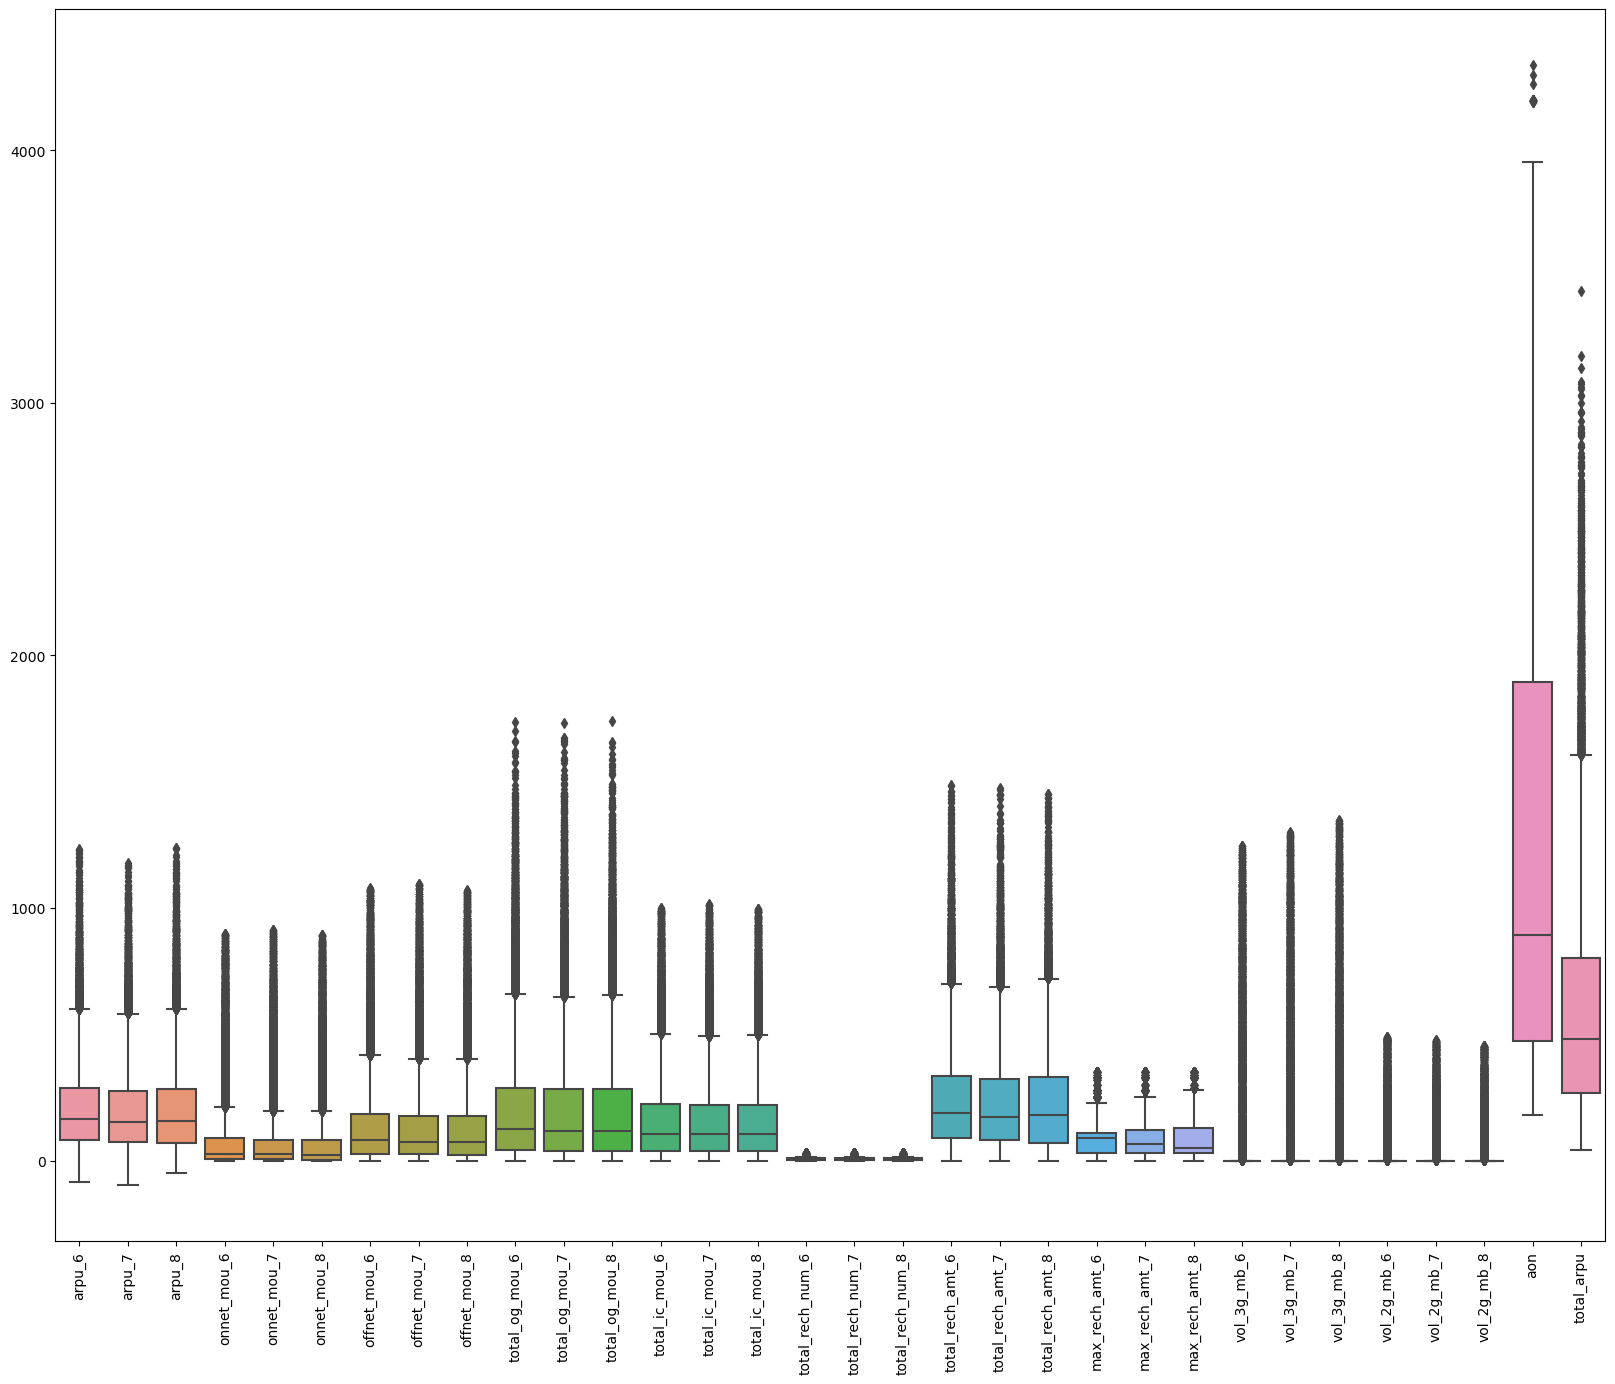

In [434]:
plt.figure(figsize=(20,16))
plt.xticks(rotation=90)
sns.boxplot(data = X_train)

We do not have much outliers as we have already removed using IQR method.

Visualizing data using Boxplot :: 

<Axes: xlabel='churn_probability', ylabel='total_arpu'>

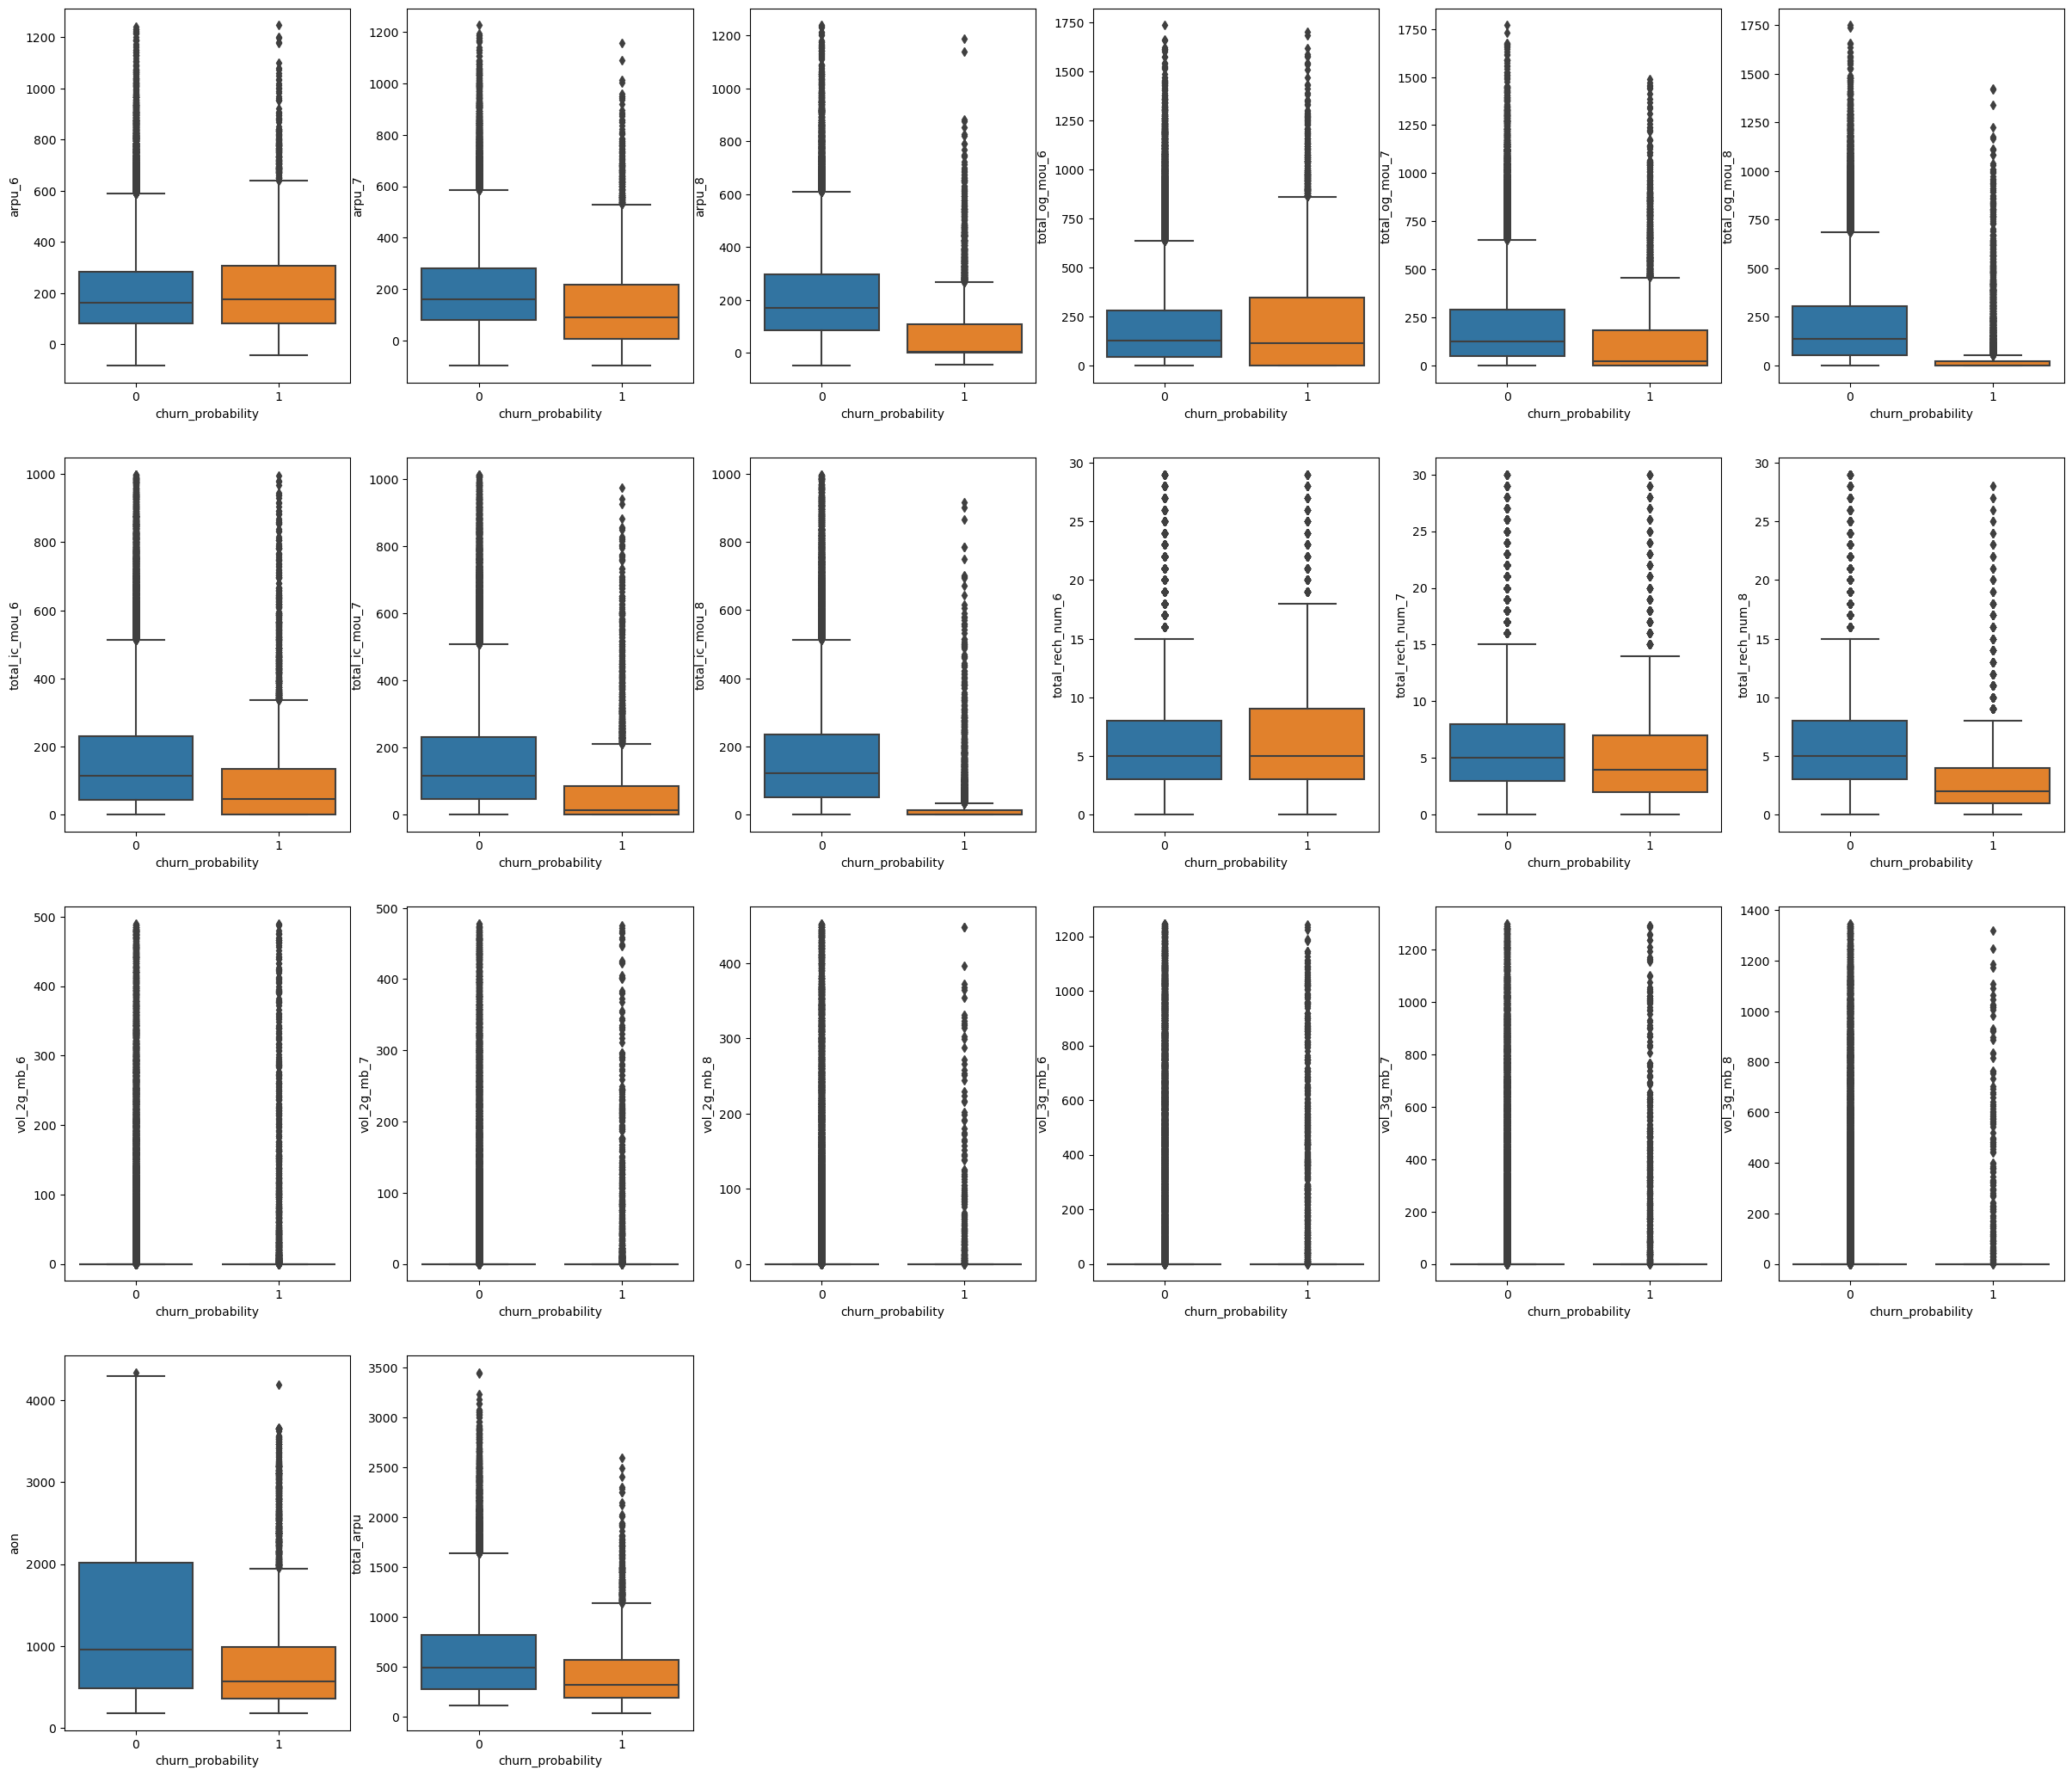

In [435]:
plt.figure(figsize=(30,26))
plt.subplot(4,6,1)
sns.boxplot(x='churn_probability', y='arpu_6', data=data_filtered)

plt.subplot(4,6,2)
sns.boxplot(x='churn_probability', y='arpu_7', data=data_filtered)

plt.subplot(4,6,3)
sns.boxplot(x='churn_probability', y='arpu_8', data=data_filtered)

plt.subplot(4,6,4)
sns.boxplot(x='churn_probability', y='total_og_mou_6', data=data_filtered)

plt.subplot(4,6,5)
sns.boxplot(x='churn_probability', y='total_og_mou_7', data=data_filtered)

plt.subplot(4,6,6)
sns.boxplot(x='churn_probability', y='total_og_mou_8', data=data_filtered)

plt.subplot(4,6,7)
sns.boxplot(x='churn_probability', y='total_ic_mou_6', data=data_filtered)

plt.subplot(4,6,8)
sns.boxplot(x='churn_probability', y='total_ic_mou_7', data=data_filtered)

plt.subplot(4,6,9)
sns.boxplot(x='churn_probability', y='total_ic_mou_8', data=data_filtered)

plt.subplot(4,6,10)
sns.boxplot(x='churn_probability', y='total_rech_num_6', data=data_filtered)

plt.subplot(4,6,11)
sns.boxplot(x='churn_probability', y='total_rech_num_7', data=data_filtered)

plt.subplot(4,6,12)
sns.boxplot(x='churn_probability', y='total_rech_num_8', data=data_filtered)

plt.subplot(4,6,13)
sns.boxplot(x='churn_probability', y='vol_2g_mb_6', data=data_filtered)

plt.subplot(4,6,14)
sns.boxplot(x='churn_probability', y='vol_2g_mb_7', data=data_filtered)

plt.subplot(4,6,15)
sns.boxplot(x='churn_probability', y='vol_2g_mb_8', data=data_filtered)

plt.subplot(4,6,16)
sns.boxplot(x='churn_probability', y='vol_3g_mb_6', data=data_filtered)

plt.subplot(4,6,17)
sns.boxplot(x='churn_probability', y='vol_3g_mb_7', data=data_filtered)

plt.subplot(4,6,18)
sns.boxplot(x='churn_probability', y='vol_3g_mb_8', data=data_filtered)

plt.subplot(4,6,19)
sns.boxplot(x='churn_probability', y='aon', data=data_filtered)

plt.subplot(4,6,20)
sns.boxplot(x='churn_probability', y='total_arpu', data=data_filtered)




### Observations
1. Average revenue per user is decreasing for churned customers
2. Total incoming and outgoing call volumes are going down for customers who are optiong out
3. Churned customers are gradually doing less number of recharges
4. New customers are more likely to churn

Check correlations ::

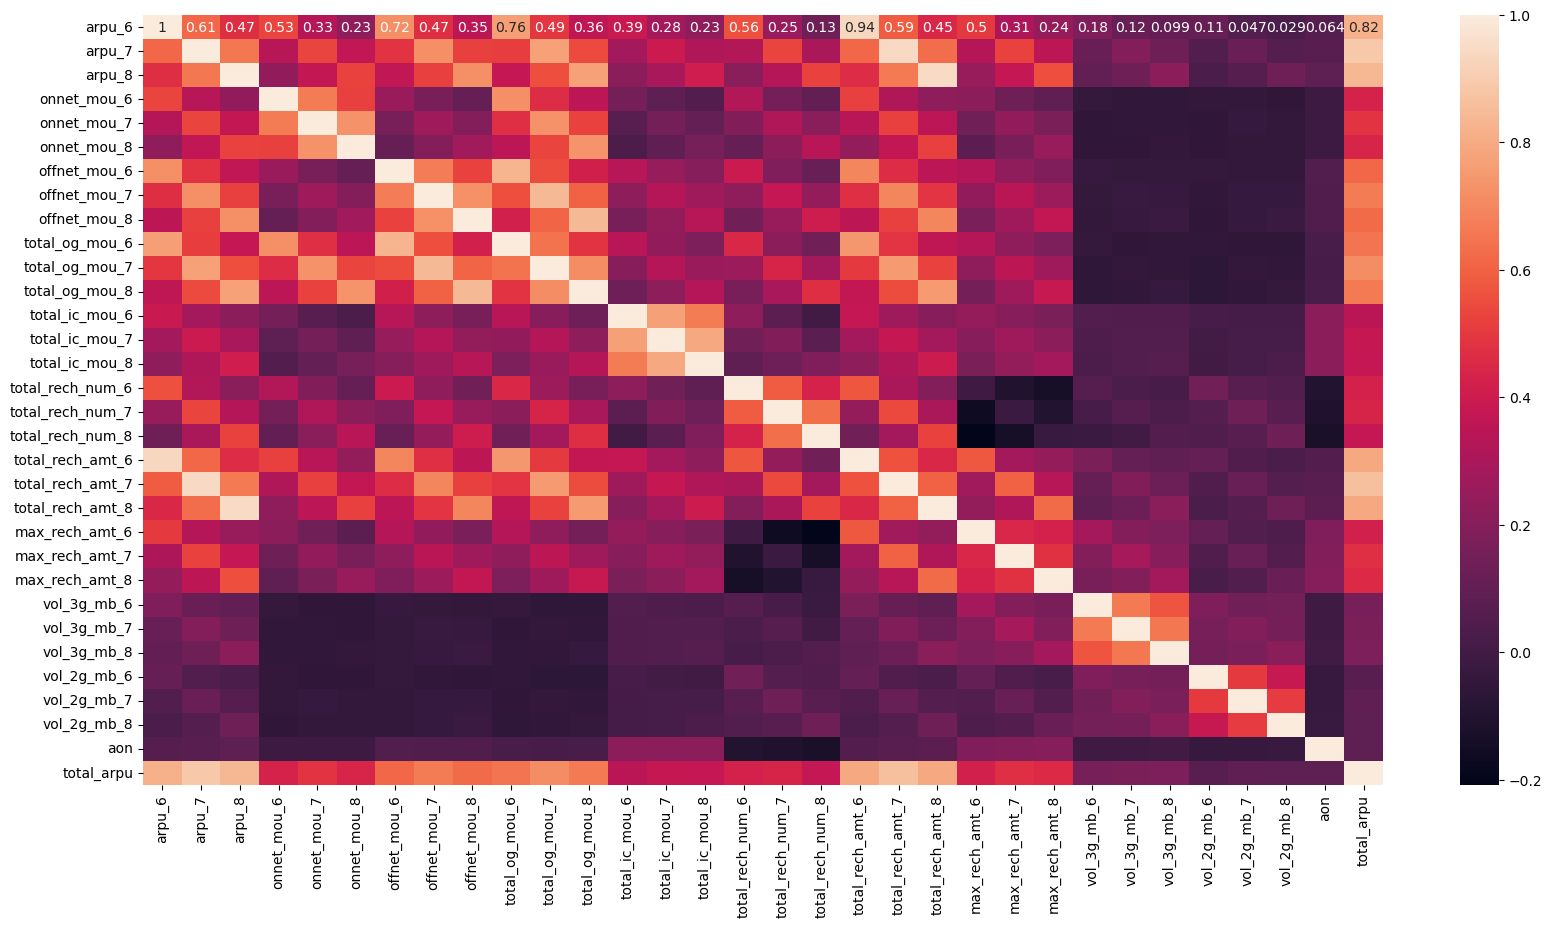

In [436]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_train.corr(),annot = True)
plt.show()

We are seeing some highly correlated dependent variables.

### 4.2 Scale Data

In [437]:
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [438]:
X_train.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
49878  141.793  168.115  154.986        60.16        48.71        32.09   
13314  385.536  424.320  445.279       103.79       139.64        99.33   
47315  400.871  435.720  344.588       435.53       531.58       173.13   
12849  779.438  315.564  387.878       110.59        11.81        67.91   
4127   117.897  305.135  119.631        30.93       125.53       143.84   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  total_og_mou_6  ...  \
49878        135.58        225.86        236.53          195.74  ...   
13314        228.29        252.88        276.09          332.09  ...   
47315        227.43        244.43        535.21          666.14  ...   
12849        382.39        145.13        211.73          248.14  ...   
4127          87.04        346.89        107.46          115.68  ...   

       max_rech_amt_7  max_rech_amt_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  \
49878             110             130          0.0          0.0          0.0   
13314              50              50          0.0          0.0          0.0   
47315             120             144          0.0          0.0          0.0   
12849             250             250          0.0          0.0          0.0   
4127              110              65          0.0          0.0          0.0   

       vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8   aon  total_arpu  
49878          0.0          0.0          0.0   656     464.894  
13314          0.0          0.0          0.0   727    1255.135  
47315          0.0          0.0          0.0   787    1181.179  
12849          0.0          0.0          0.0  1778    1482.880  
4127           0.0          0.0          0.0   626     542.663  

[5 rows x 32 columns]

<Axes: >

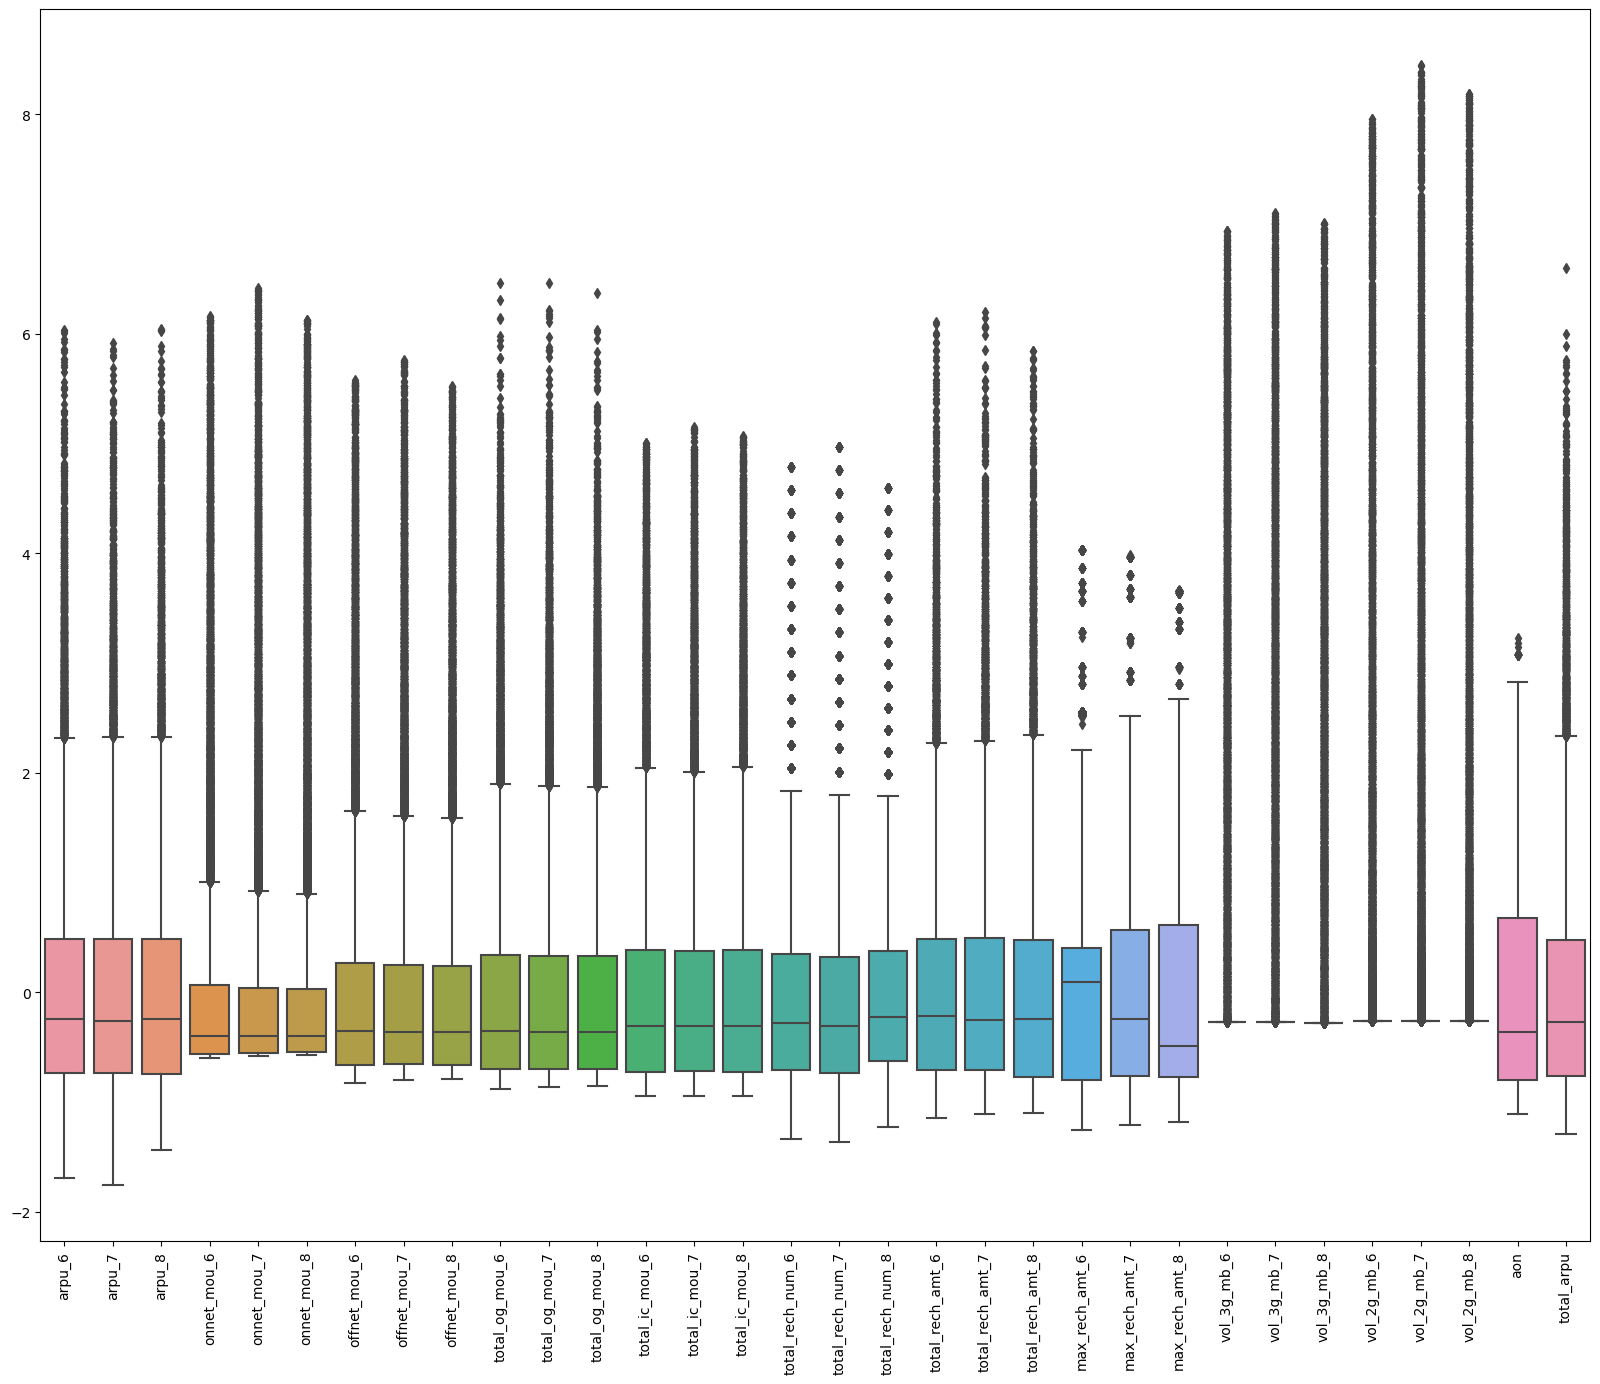

In [439]:
plt.figure(figsize=(20,16))
plt.xticks(rotation=90)
sns.boxplot(data = pd.DataFrame(X_train_scaled, columns = X_train.columns))

<Axes: xlabel='churn_probability', ylabel='Count'>

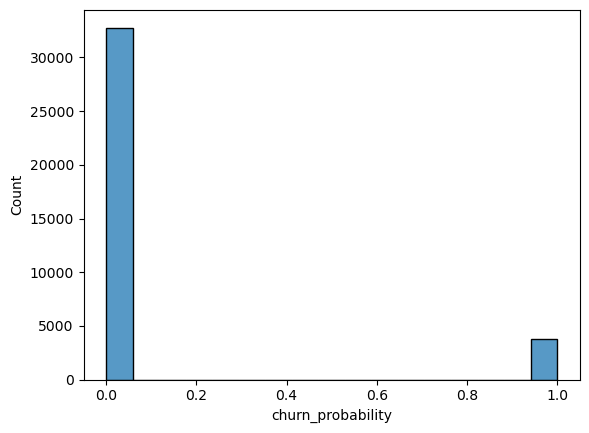

In [440]:
#Distribution for the churn probability
sns.histplot(y_train)

In [441]:
### Checking the Churn Rate
churn = (sum(data['churn_probability'])/len(data['churn_probability'].index))*100
churn

10.188716981671167

Data is highly imbalanced. We have only 10% churn rate.

## 5. Model Building
Will start with simple models and check model performances.

### 5.1 Logistic Regression without using RFE

In [442]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg1 = LogisticRegression()

In [443]:
logreg1.fit(X_train_scaled, y_train)

LogisticRegression()

In [444]:
y_pred = logreg1.predict(X_test_scaled)
y_pred_prob = logreg1.predict_proba(X_test_scaled)

In [445]:
## Define method for model performance
def model_metrics(y_test, y_pred, y_pred_prod):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prod)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC Score: {roc_auc}')

model_metrics(y_test, y_pred, y_pred_prob[:,1])

Accuracy: 0.9159813858609039
Precision: 0.731675392670157
Recall: 0.33433014354066987
F1 Score: 0.45894909688013136
ROC AUC Score: 0.8963245975347669


In [446]:
confusion = metrics.confusion_matrix(y_test, y_pred )
confusion

array([[13810,   205],
       [ 1113,   559]])

Getting very low Recall and Precision. Will use RFE to select variables.

### 5.2 Logistic Regression using RFE

In [447]:
from sklearn.feature_selection import RFE
logreg2 = LogisticRegression()
rfe = RFE(logreg2, n_features_to_select=20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train_scaled, y_train)

In [448]:
## View selected features
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 4),
 ('arpu_8', False, 5),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('total_og_mou_6', True, 1),
 ('total_og_mou_7', True, 1),
 ('total_og_mou_8', True, 1),
 ('total_ic_mou_6', True, 1),
 ('total_ic_mou_7', True, 1),
 ('total_ic_mou_8', True, 1),
 ('total_rech_num_6', False, 3),
 ('total_rech_num_7', False, 9),
 ('total_rech_num_8', True, 1),
 ('total_rech_amt_6', False, 11),
 ('total_rech_amt_7', False, 6),
 ('total_rech_amt_8', False, 12),
 ('max_rech_amt_6', False, 2),
 ('max_rech_amt_7', True, 1),
 ('max_rech_amt_8', True, 1),
 ('vol_3g_mb_6', False, 7),
 ('vol_3g_mb_7', False, 8),
 ('vol_3g_mb_8', True, 1),
 ('vol_2g_mb_6', False, 13),
 ('vol_2g_mb_7', False, 10),
 ('vol_2g_mb_8', True, 1),
 ('aon', True, 1),
 ('total_arpu', True, 1)]

In [449]:
rfe_selected_col = X_train.columns[rfe.support_]
rfe_selected_col

Index(['arpu_6', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_8', 'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_8',
       'vol_2g_mb_8', 'aon', 'total_arpu'],
      dtype='object')

In [450]:
## Train the logistic regression model using the selected features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

In [451]:
## Train the model
logreg2.fit(X_train_rfe, y_train)

LogisticRegression()

In [452]:
## Make predictions
y_pred_rfe = logreg2.predict(X_test_rfe)
y_pred_prob_rfe = logreg2.predict_proba(X_test_rfe)
y_pred_rfe[:10]

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [453]:
## Check model performance
model_metrics(y_test, y_pred_rfe,y_pred_prob_rfe[:,1])


Accuracy: 0.9167463504812903
Precision: 0.7340153452685422
Recall: 0.34330143540669855
F1 Score: 0.46780766096169524
ROC AUC Score: 0.895860936761194


In [454]:
confusion = metrics.confusion_matrix(y_test, y_pred_rfe )
confusion

array([[13807,   208],
       [ 1098,   574]])

Not seeing any improvement in accuracy. Recall and precision are still low. Checking VIFs

In [455]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [456]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_selected_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_selected_col].values, i) for i in range(X_train[rfe_selected_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9     total_og_mou_8  113.43
8     total_og_mou_7  107.17
7     total_og_mou_6   65.54
6       offnet_mou_8   57.47
5       offnet_mou_7   55.95
4       offnet_mou_6   39.30
19        total_arpu   39.08
3        onnet_mou_8   30.06
2        onnet_mou_7   29.02
0             arpu_6   23.82
1        onnet_mou_6   20.44
11    total_ic_mou_7    8.12
12    total_ic_mou_8    6.32
10    total_ic_mou_6    5.91
15    max_rech_amt_8    4.07
14    max_rech_amt_7    3.93
13  total_rech_num_8    3.26
18               aon    2.53
16       vol_3g_mb_8    1.37
17       vol_2g_mb_8    1.19

There are multiple variables with very high VIF. High VIF variables should not help much with prediction. Lets start dropping and check accuracy.

In [457]:
logreg3 = LogisticRegression()
rfe2 = RFE(logreg3, n_features_to_select=10)             # running RFE with 10 variables as output
rfe2 = rfe2.fit(X_train_scaled, y_train)

In [458]:
## Train the logistic regression model using the selected features
X_train_rfe2 = rfe2.transform(X_train_scaled)
X_test_rfe2 = rfe2.transform(X_test_scaled)

In [459]:
## Train the model
logreg3.fit(X_train_rfe2, y_train)

LogisticRegression()

In [460]:
## Make predictions
y_pred_rfe2 = logreg3.predict(X_test_rfe2)
y_pred_prob_rfe2 = logreg3.predict_proba(X_test_rfe2)
y_pred_rfe2[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [461]:
## Check model performance
model_metrics(y_test, y_pred_rfe2, y_pred_prob_rfe2[:,1])


Accuracy: 0.9185950149805572
Precision: 0.7535301668806161
Recall: 0.35107655502392343
F1 Score: 0.4789881680946551
ROC AUC Score: 0.894554962471856


In [462]:
confusion = metrics.confusion_matrix(y_test, y_pred_rfe2 )
confusion

array([[13823,   192],
       [ 1085,   587]])

Still accurancy is same. Not much improvement in Recall and Precision.

In [463]:
## Check RFE selected columns
rfe_selected_col = X_train.columns[rfe2.support_]
rfe_selected_col

Index(['onnet_mou_8', 'offnet_mou_8', 'total_og_mou_8', 'total_ic_mou_8',
       'total_rech_num_8', 'max_rech_amt_7', 'max_rech_amt_8', 'vol_2g_mb_8',
       'aon', 'total_arpu'],
      dtype='object')

In [464]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_selected_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_selected_col].values, i) for i in range(X_train[rfe_selected_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
2    total_og_mou_8  85.70
1      offnet_mou_8  42.35
0       onnet_mou_8  21.67
9        total_arpu   7.36
5    max_rech_amt_7   3.74
6    max_rech_amt_8   3.65
4  total_rech_num_8   2.98
3    total_ic_mou_8   2.42
8               aon   2.41
7       vol_2g_mb_8   1.16

Getting decent accuracy and roc-auc scores with above models but getting very low Recall and Precision. So from business perspective these models will not give much value.


### 5.3 RandomForest

In [465]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [466]:
## make prediction
y_pred_randomforest = rf.predict(X_test)
y_pred_prob_randomforest = rf.predict_proba(X_test)

In [467]:
## Check model performance
model_metrics(y_test,y_pred_randomforest, y_pred_prob_randomforest[:,1])


Accuracy: 0.8923949767323262
Precision: 0.25
Recall: 0.004784688995215311
F1 Score: 0.009389671361502346
ROC AUC Score: 0.654323887427517


In [468]:
confusion = metrics.confusion_matrix(y_test, y_pred_randomforest )
confusion

array([[13991,    24],
       [ 1664,     8]])

Though getting decent accuracy score, Precision, Recall and F1 scores are very low.

In [469]:
## Lets plot the important variables as per RandomForest 
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})

<BarContainer object of 32 artists>

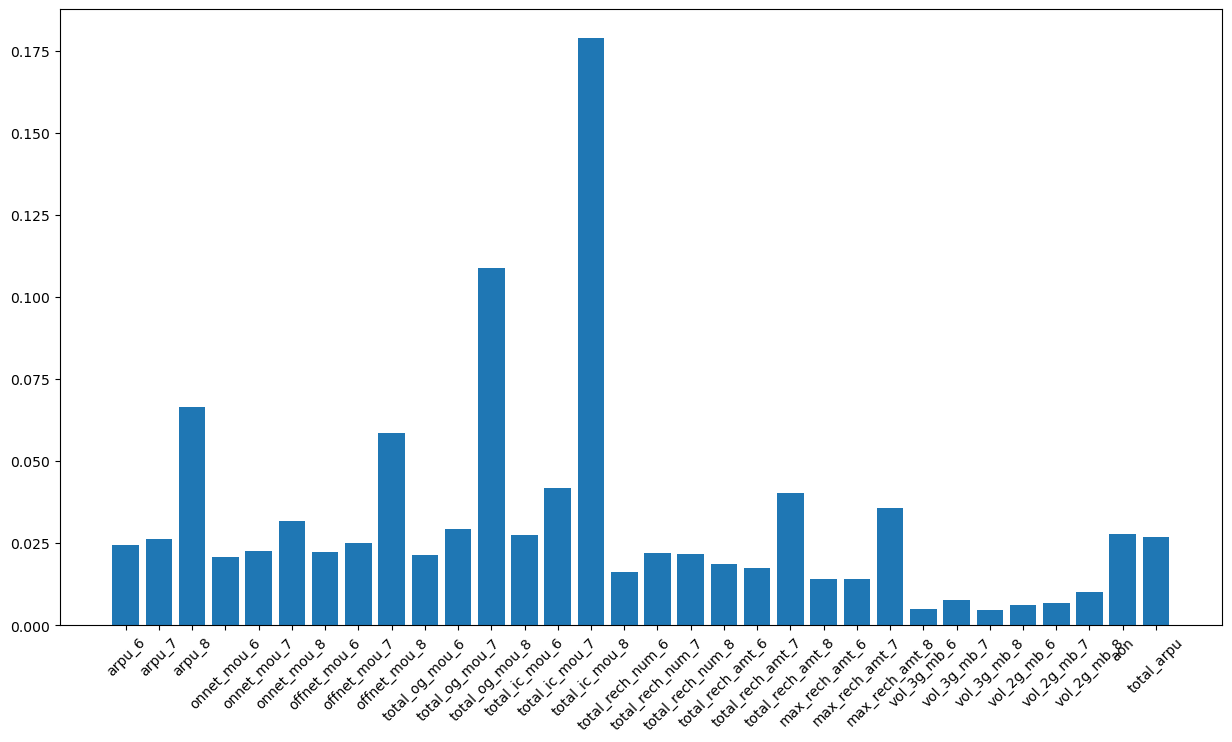

In [470]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

### 5.4 Logistic Regression using PCA
Lets build LR model using Principal Component Analysis

In [471]:
pca = PCA(random_state=42)

In [472]:
pca.fit(X_train_scaled)

PCA(random_state=42)

In [473]:
pca.components_

array([[ 2.32644083e-01,  2.64083508e-01,  2.46229074e-01, ...,
         1.52467542e-02,  2.94479697e-02,  2.91750067e-01],
       [ 5.40513333e-02,  4.29370663e-02,  4.50319921e-02, ...,
         2.19085518e-01,  1.01959958e-01,  5.58266595e-02],
       [-2.32600088e-01,  4.62171956e-02,  2.25246039e-01, ...,
         2.02066145e-01, -1.56733532e-01,  1.59508364e-02],
       ...,
       [ 8.22423902e-02, -2.60755233e-02, -3.95088977e-02, ...,
         3.91020989e-03,  1.28480052e-03,  6.61601019e-03],
       [-1.52096134e-02,  4.80538177e-02, -3.32058156e-02, ...,
         3.15855692e-03,  6.66523000e-04, -7.17411205e-04],
       [ 3.25962998e-01,  3.18695448e-01,  3.29756979e-01, ...,
         3.67699952e-17,  1.02203666e-17, -8.26705311e-01]])

In [474]:
pca.explained_variance_ratio_

array([3.37216846e-01, 1.01035892e-01, 8.04182242e-02, 7.60058875e-02,
       6.48106055e-02, 4.99488394e-02, 4.62848072e-02, 4.06795150e-02,
       2.76408341e-02, 2.26616209e-02, 2.06995575e-02, 1.64060240e-02,
       1.51512279e-02, 1.32045412e-02, 1.18290040e-02, 1.15290650e-02,
       1.05462481e-02, 8.84976909e-03, 8.58776488e-03, 7.86501500e-03,
       6.18840597e-03, 5.43250034e-03, 4.70191380e-03, 3.75294543e-03,
       2.94642083e-03, 1.74946664e-03, 1.45314486e-03, 1.16749776e-03,
       7.48739277e-04, 3.15445164e-04, 1.72231928e-04, 1.69569563e-31])

#### Creating scree plot to determine number of variables for PCA

In [475]:
varCumulativeSum = np.cumsum(pca.explained_variance_ratio_)

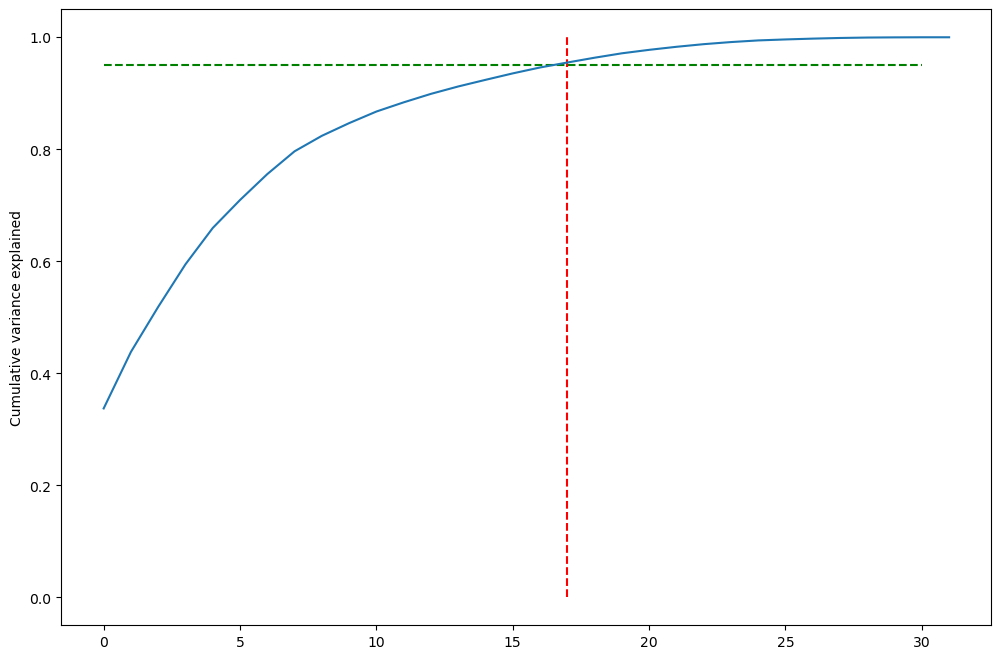

In [476]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=17, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(varCumulativeSum)
plt.ylabel("Cumulative variance explained")
plt.show()

About 95% variance is explained by 17 variables. So we will go-ahead with 17 variables.

In [477]:
### Perform PCA with 17 components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=17)

In [478]:
df_train_pca = pca_final.fit_transform(X_train_scaled)
df_test_pca = pca_final.transform(X_test)

In [479]:
df_train_pca.shape

(36602, 17)

In [480]:
# putting correlation matrix for df_train_pca
correlation_matrix = np.corrcoef(df_train_pca.transpose())

In [481]:
correlation_matrix.shape

(17, 17)

<Axes: >

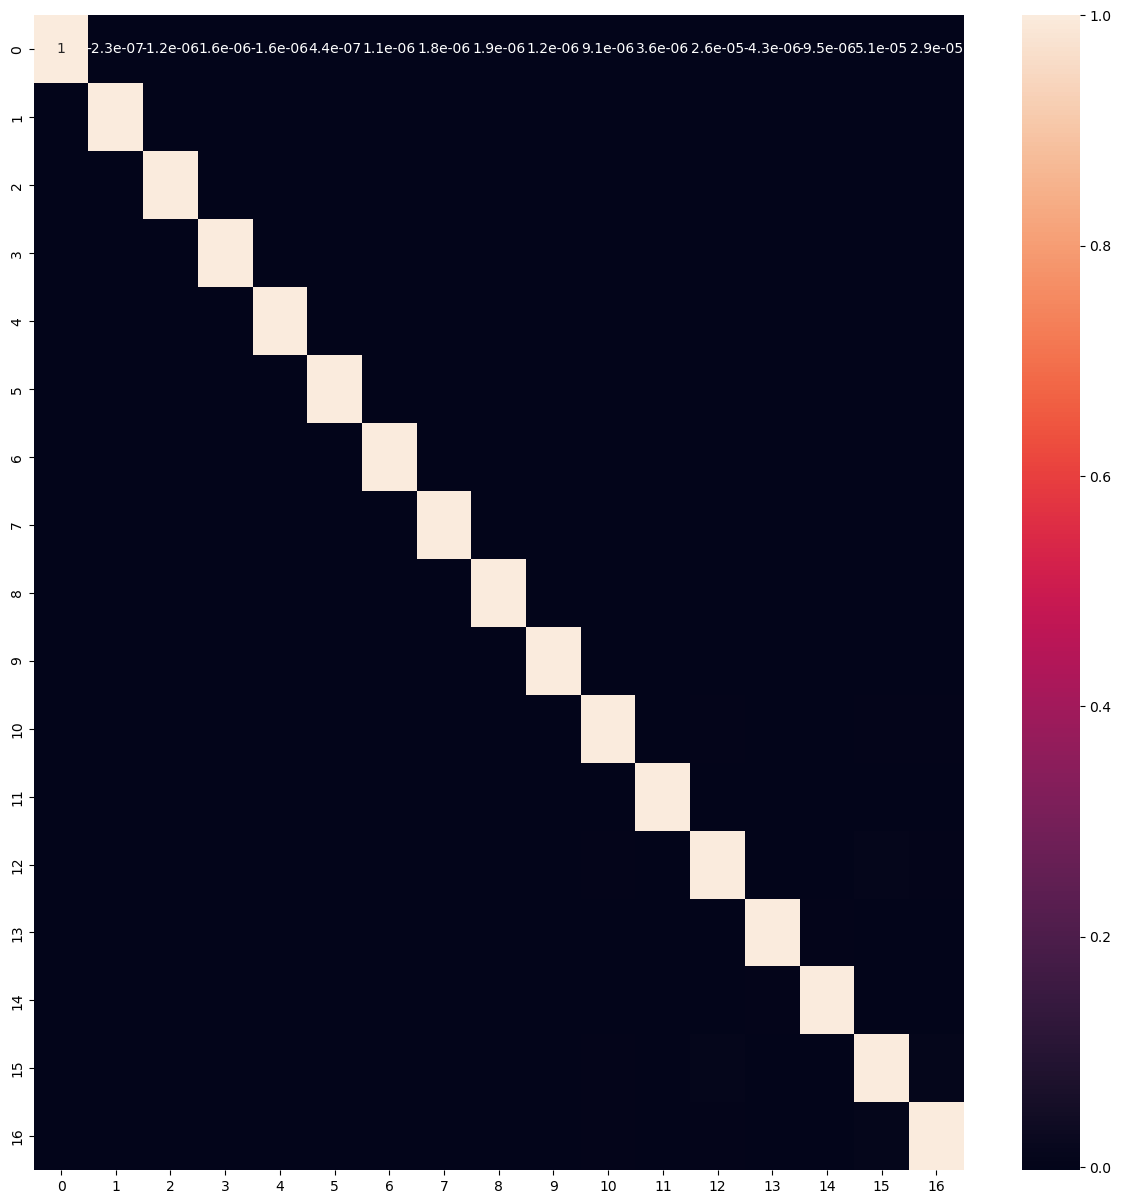

In [482]:
plt.figure(figsize=[15,15])
sns.heatmap(correlation_matrix, annot=True)

Not seeing any highly correlated variables

#### Applying Logistic Regression on the Principal Components

In [483]:
logistic_pca = LogisticRegression(max_iter=1000, tol=0.001, solver='sag') # Using solver algo as sag

In [484]:
## Train the model
model_pca = logistic_pca.fit(df_train_pca, y_train)

In [485]:
## Make predictions using model
y_pred_pca = model_pca.predict(df_test_pca)
y_pred_prob_pca = model_pca.predict_proba(df_test_pca)

In [486]:
## Model performance
model_metrics(y_test, y_pred_pca, y_pred_prob_pca[:,1])


Accuracy: 0.8879964301651049
Precision: 0.4536532170119956
Recall: 0.24880382775119617
F1 Score: 0.3213595983005021
ROC AUC Score: 0.7867491597348706


In [487]:
confusion = metrics.confusion_matrix(y_test, y_pred_pca )
confusion

array([[13514,   501],
       [ 1256,   416]])

Decent accuracy but other very low parameters

### 5.5 Logistic Regression using Unsupervised PCA

In [488]:
pca_unsupervised = PCA(0.9) # select min components to explain 90% of the variance

In [489]:
df_train_pca_unsupervised = pca_unsupervised.fit_transform(X_train_scaled)

In [490]:
df_train_pca_unsupervised.shape

(36602, 14)

In [491]:
logistic_pca_unsupervised = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')

In [492]:
## Fit the model
model_pca_unsupervised = logistic_pca_unsupervised.fit(df_train_pca_unsupervised, y_train)

In [493]:
df_test_pca_unsupervised = pca_unsupervised.transform(X_test)
df_test_pca_unsupervised.shape

(15687, 14)

In [494]:
## Make predictions
y_pred_prob_pca_unsupervised = model_pca_unsupervised.predict_proba(df_test_pca_unsupervised)
y_pred_pca_unsupervised = model_pca_unsupervised.predict(df_test_pca_unsupervised)

In [495]:
## Check model performance
model_metrics(y_test, y_pred_pca_unsupervised, y_pred_prob_pca_unsupervised[:,1])

Accuracy: 0.8973034997131383
Precision: 0.7074829931972789
Recall: 0.06220095693779904
F1 Score: 0.11434854315557998
ROC AUC Score: 0.799182629854889


Still Recall is very low.

As the data is higly imbalanced, we are not getting decent performance from simple models. Next we will try Synthetic Minority Over-sampling (SMOTE) which is a proven technique to handle highly imbalanced data.

### 5.6 Logistic Regression using SMOTE

We have only 10% churn rate in the given dataset. So data is highly imbalanced. Applying Synthetic Minority Over-sampling Technique.

In [496]:
from imblearn.over_sampling import SMOTE

In [497]:
smote = SMOTE(random_state=42)

In [498]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [499]:
## Scale the data
scaler4 = StandardScaler()
X_train_smote_scaled = scaler4.fit_transform(X_train_smote)
X_test_smote_scaled = scaler4.transform(X_test)


In [500]:
## Create Logistic Regression model
lr_smote = LogisticRegression()

In [501]:
## Train the model
lr_smote.fit(X_train_smote_scaled, y_train_smote)

LogisticRegression()

In [502]:
## Make predictions
y_pred_smote = lr_smote.predict(X_test_smote_scaled)
y_pred_prob_smote = lr_smote.predict_proba(X_test_smote_scaled)[:,1]

In [503]:
## Check model performance
model_metrics(y_test, y_pred_smote, y_pred_prob_smote)

Accuracy: 0.8110537387645821
Precision: 0.3426692644909888
Recall: 0.8415071770334929
F1 Score: 0.4870197300103842
ROC AUC Score: 0.8905561283450576


We are getting decent Recall with this model but accuracy is low. Lets apply hypertuning and k-fold cross validation.

### 5.7 Logistic Regression with GridSearchCV hypertuning and StratifiedKFold for KFold cross validations

In [504]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline

In [505]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [506]:
param_grid = {
    'logreg__C': [.01,.1,1,10,100],
    'logreg__penalty': ['l1','l2'],
    'logreg__solver': ['liblinear']
}

In [507]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [508]:
grid_search = GridSearchCV(pipeline,param_grid,cv=kfold, scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)},
                           refit='accuracy', verbose=1)

In [509]:
grid_search.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.01, 0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [510]:
model = grid_search.best_estimator_

In [511]:
y_pred_grid = model.predict(X)
y_pred_prob_grid = model.predict_proba(X)[:,1]

In [512]:
model_metrics(y, y_pred_grid, y_pred_prob_grid)

Accuracy: 0.8140144198588614
Precision: 0.3416897403277707
Recall: 0.8310884601383327
F1 Score: 0.4842763960333033
ROC AUC Score: 0.8885849692636942


Not much improved. Next will try RandomClassifier with hyperparameter tuning and k-fold cross validation.

#### 5.8 RandomClassifier with GridSearchCV hypertuning and StratifiedKFold for KFold cross validation

In [513]:
## Using class_weight feature for highly imbalanced data
random_classifier_gs = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') 

In [514]:
param_grid = {
    'max_depth': [5,10,15,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True, False]
}

In [515]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [516]:
grid_search = GridSearchCV(estimator=random_classifier_gs,
                           param_grid=param_grid,
                           cv=kfold, 
                           scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)},
                           refit='accuracy', 
                           verbose=1, 
                           n_jobs=-1)

In [517]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [518]:
## Select best model
model = grid_search.best_estimator_

In [519]:
## Predict
y_pred_rf_grid = model.predict(X_test)
y_pred_prob_rf_grid = model.predict_proba(X_test)[:,1]

In [520]:
accuracy = accuracy_score(y_test, y_pred_rf_grid)
accuracy

0.9451137884872824

In [521]:
## Model Performance
model_metrics(y_test, y_pred_rf_grid, y_pred_prob_rf_grid)

Accuracy: 0.9451137884872824
Precision: 0.7877927608232789
Recall: 0.6638755980861244
F1 Score: 0.7205452775073028
ROC AUC Score: 0.9241177642887746


We are seeing singnificant improvement in most of the parameters. But still Recall is decent. Check the feature importance::

In [363]:
## Get feature importance by the model
impt_features = model.feature_importances_

In [364]:
important_feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': impt_features}).sort_values(by='Importance', ascending=False)
print(important_feature_df)

             Feature  Importance
14    total_ic_mou_8    0.186778
11    total_og_mou_8    0.110792
8       offnet_mou_8    0.073900
2             arpu_8    0.070093
20  total_rech_amt_8    0.050084
13    total_ic_mou_7    0.048728
23    max_rech_amt_8    0.047888
10    total_og_mou_7    0.035137
5        onnet_mou_8    0.031911
30               aon    0.029626
12    total_ic_mou_6    0.026014
7       offnet_mou_7    0.023610
17  total_rech_num_8    0.023165
1             arpu_7    0.022896
4        onnet_mou_7    0.020656
9     total_og_mou_6    0.020371
31        total_arpu    0.019248
0             arpu_6    0.018894
19  total_rech_amt_7    0.018252
6       offnet_mou_6    0.017661
3        onnet_mou_6    0.017399
16  total_rech_num_7    0.014494
18  total_rech_amt_6    0.014293
15  total_rech_num_6    0.012303
22    max_rech_amt_7    0.010118
21    max_rech_amt_6    0.009777
29       vol_2g_mb_8    0.007100
28       vol_2g_mb_7    0.004586
26       vol_3g_mb_8    0.004246
27       v

Important variables according to this model are ::
1. Total incoming in the month of August
2. Total outgoing in the month of August
3. Monthly usage offnetwork in the month of August
4. Total recharge amount in the month of August
5. Total incoming in the month of July
6. Average revenue per user in the August
7. Maximum recharge amount in the month of August
8. Total outgoing in the month of July
9. Average time on the network

#### 5.9 Apply XGBoost with SMOTE
XGBoost is highly effective for imbalanced dataset. Trying XGBoost with SMOTE sampled data.

In [566]:
import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', message="/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158")

In [567]:
## Handling class imbalance using SMOTE
smote2 = SMOTE(random_state=42)
X_somte2, y_smote2 = smote2.fit_resample(X, y)

In [568]:
## Split the data
X_train,X_test,y_train,y_test = train_test_split(X_somte2, y_smote2, test_size=0.3, random_state=42)

In [569]:
## Define model and fit the training data
xgboost_model = xgb.XGBClassifier( 
                                  scale_pos_weight=len(y[y==0]) / len(y[y==1]), # Account for class imbalance
                                  max_depth=5,
                                  learning_rate=0.1,
                                  reg_alpha=0.1, # Lasso
                                  reg_lambda=0.1 # Ridge
                                 )
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [570]:
## Predict
y_pred_xgboost = xgboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgboost)
accuracy

0.8479894575631299

Getting decent accuracy. Lets tune hyperparametes using GridSearchCV. Also use K-fold cross validations

In [571]:
param_grid = {
    'max_depth': [5,10,15],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1,1],
    'reg_lambda': [1, 1.5, 2]
}

In [574]:
kfold2 = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [575]:
grid_search2 = GridSearchCV(estimator=xgboost_model, 
                            param_grid=param_grid,
                            cv=kfold2, 
                            scoring={'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)},
                            refit='accuracy', 
                            verbose=1, n_jobs=-1)

In [576]:
## Train the data
grid_search2.fit(X_train, y_train)

Fitting 8 folds for each of 81 candidates, totalling 648 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 10, 15], 'reg_alpha': [0, 0.1, 1],
                         'reg_lambda': [1, 1.5, 2]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)},
             verbose=1)

In [577]:
## Select best model
model_xgboost_grid = grid_search2.best_estimator_

In [578]:
## Predict
y_pred_xg_grid = model_xgboost_grid.predict(X_test)
y_pred_prob_xg_grid = model_xgboost_grid.predict_proba(X_test)[:,1]
model_metrics(y_test, y_pred_xg_grid, y_pred_prob_xg_grid)


Accuracy: 0.9579014852014104
Precision: 0.9387307032590051
Recall: 0.9793142938944958
F1 Score: 0.9585931479016325
ROC AUC Score: 0.9917934943179935


In [376]:
## Selected Best Parameters
print("Best Paramaters:", grid_search2.best_params_)

Best Paramaters: {'learning_rate': 0.2, 'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 1.5}


##### This is the best model we have got so far with excellent accuracy, precision and recall. If the cost of targeting non churning customers with offer is high, then we can use this model as it has ~93% precision. Also we have got excellent recall of ~97%, which minimises chance of missing churn customers. Check the feature importance for this model :: 

In [377]:
## Get feature importance by the model
impt_features_xgboost = model_xgboost_grid.feature_importances_

In [378]:
important_feature_xgboost_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': impt_features_xgboost}).sort_values(by='Importance', ascending=False)
print(important_feature_xgboost_df)

             Feature  Importance
14    total_ic_mou_8    0.306726
23    max_rech_amt_8    0.062528
22    max_rech_amt_7    0.041261
21    max_rech_amt_6    0.038101
26       vol_3g_mb_8    0.033899
29       vol_2g_mb_8    0.030651
13    total_ic_mou_7    0.028780
17  total_rech_num_8    0.027010
11    total_og_mou_8    0.023839
30               aon    0.022989
20  total_rech_amt_8    0.022250
10    total_og_mou_7    0.021738
19  total_rech_amt_7    0.021565
4        onnet_mou_7    0.018716
12    total_ic_mou_6    0.018573
5        onnet_mou_8    0.018398
2             arpu_8    0.018216
18  total_rech_amt_6    0.018047
28       vol_2g_mb_7    0.018014
9     total_og_mou_6    0.017777
27       vol_2g_mb_6    0.017498
7       offnet_mou_7    0.017272
1             arpu_7    0.017109
16  total_rech_num_7    0.016763
15  total_rech_num_6    0.016629
0             arpu_6    0.016510
8       offnet_mou_8    0.015856
31        total_arpu    0.015477
24       vol_3g_mb_6    0.015447
3        o

Important features according to this model are ::
1. Total incoming in the month of August
2. Maximum recharge amount in the month of August
3. Maximum recharge amount in the month of Jun and July
4. Total recharge amount in the month of August
5. Volume of 3G data used in the month of August
6. Total outgoing in the month of July
7. Total incoming in the month of July

We are seeing many similar important variables between in this model and previous one.

## 6. Business Recommendation
Based on the analysis done with data and above models, below are some parameters to check to improve churn rate:

1. __Decrease in Incoming or Outgoing calls__ :: If there is decrease in incoming or outgoing calls, customer may churn. Those customers need to be identified and offer competitive rate plans.
2. __Recharge amount__ :: Declining recharge amount indicates churning customers. Corrective actions can be taken after identifying those customers.
3. __Average Revenue per customer__ :: Declining revenue also indicates churning customers. Identified customers can be given special offers.
4. __Data Usage__ :: Customers who are reducing data usage may be thinking of switching to diffrenet provider. Business should idenfity churning segment based on this parameter.
5. __Maximum recharge amount__ :: Declining recharge amount also may indicate churning customers. Necessary actions can be taken on that segment.
6. __Age on netwrok__ :: New customers on the netwrok tend to switch more than old customers. Business should identify this segment and incentivize.


## 7. Summary
In this case-study we have developed following models:

1. Logistic Regression 
2. Logistic Regression with RFE
3. Random Forest 
4. Logistic Regression using PCA
5. Logistic Regression using unsuervised PCA
6. Logistic Regression using SMOTE
7. Logistic Regression using GridSearch and KFold
8. Random Forest using GridSearch and KFold
9. XGBoost with SMOTE, GridSearch and KFold

Among all these models, __"XGBoost with SMOTE, GridSearch and KFold"__ is showing high accuracy, precision and recall. But showing less accuracy in unseen data. Whereas __Random Forest using GridSearch and KFold__ is showing high accuracy and pretty decent precision and recall and also maintaining same level of accuracy in unseen data. In the context of telecom churn, where minimizing false negative is crucial, Recall should be the most important selection criteria while maintaining the accuracy of the model in unseen data. So based
on this, __Random Forest using GridSearch and KFold__ model will be most suitable in this context.

### Submission File

In [552]:
sample.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [553]:
unseen_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8   aon  \
0   65.330  ...            0        NaN        NaN        NaN  1692   
1  515.568  ...            0        NaN        NaN        NaN  2533   
2  434.884  ...            0        NaN        NaN        NaN   277   
3  171.390  ...            0        NaN        NaN        NaN  1244   
4  406.289  ...            0        NaN        NaN        NaN   462   

   aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  total_arpu  
0        0.00        0.00        0.00                  0     221.657  
1        0.00        0.00        0.00                  0    1290.604  
2      525.61      758.41      241.84                  1    1510.967  
3        0.00        0.00        0.00                  0     239.340  
4        0.00        0.00        0.00                  0    1126.472  

[5 rows x 173 columns]

In [554]:
unseen_data.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  30000.000000    30000.0         29684.0         29684.0   
mean   84998.500000      109.0             0.0             0.0   
std     8660.398374        0.0             0.0             0.0   
min    69999.000000      109.0             0.0             0.0   
25%    77498.750000      109.0             0.0             0.0   
50%    84998.500000      109.0             0.0             0.0   
75%    92498.250000      109.0             0.0             0.0   
max    99998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         29684.0  30000.000000  30000.000000  30000.000000  28831.000000   
mean              0.0    282.644348    279.355021    279.845167    130.629693   
std               0.0    314.560212    323.205370    326.437029    290.677420   
min               0.0   -185.043000  -2014.045000   -146.859000      0.000000   
25%               0.0     92.907500     87.504750     84.180500      7.280000   
50%               0.0    198.227500    191.775000    191.690500     34.760000   
75%               0.0    371.969250    365.250750    367.804750    117.170000   
max               0.0  10955.066000  13224.119000  13505.996000   6944.360000   

        onnet_mou_7  ...   sachet_3g_8    fb_user_6    fb_user_7    fb_user_8  \
count  28828.000000  ...  30000.000000  7585.000000  7706.000000  7922.000000   
mean     133.148632  ...      0.082200     0.909954     0.906956     0.891946   
std      302.921820  ...      0.611546     0.286267     0.290513     0.310468   
min        0.000000  ...      0.000000     0.000000     0.000000     0.000000   
25%        6.660000  ...      0.000000     1.000000     1.000000     1.000000   
50%       32.550000  ...      0.000000     1.000000     1.000000     1.000000   
75%      115.210000  ...      0.000000     1.000000     1.000000     1.000000   
max     7411.010000  ...     30.000000     1.000000     1.000000     1.000000   

                aon    aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  \
count  30000.000000  30000.000000  30000.000000  30000.000000   
mean    1218.023200     68.314097     68.946576     59.891621   
std      960.109844    263.460641    278.749349    246.098292   
min      180.000000      0.000000      0.000000      0.000000   
25%      466.000000      0.000000      0.000000      0.000000   
50%      853.000000      0.000000      0.000000      0.000000   
75%     1795.000000      0.000000      0.000000      0.000000   
max     4197.000000   6054.390000   7994.840000   6614.530000   

       churn_probability    total_arpu  
count       30000.000000  30000.000000  
mean            0.081867    841.844536  
std             0.274166    855.860893  
min             0.000000     42.400000  
25%             0.000000    316.772250  
50%             0.000000    592.940500  
75%             0.000000   1068.558500  
max             1.000000  33070.522000  

[8 rows x 164 columns]

In [555]:
unseen_data['churn_probability'] = 0
unseen_data['total_arpu'] = unseen_data.apply(lambda row: row['arpu_6'] + row['arpu_7'] + row['arpu_8'], axis=1)

In [556]:
submission_data = unseen_data.set_index('id')[X_test.columns]

In [557]:
submission_data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
69999   91.882   65.330   64.445        31.78        20.23        23.11   
70000  414.168  515.568  360.868        75.51        41.21        19.84   
70001  329.844  434.884  746.239         7.54         7.86         8.40   
70002   43.550  171.390   24.400         5.31         2.16         0.00   
70003  306.854  406.289  413.329       450.93       609.03       700.68   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  total_og_mou_6  ...  \
id                                                               ...   
69999         60.16         32.16         34.83           91.94  ...   
70000        474.34        621.84        394.94          549.86  ...   
70001         16.98         45.81         45.04            0.00  ...   
70002         40.04        205.01         24.01           45.36  ...   
70003         60.94         23.84         74.16          514.79  ...   

       max_rech_amt_7  max_rech_amt_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  \
id                                                                             
69999              30              30          0.0          0.0          0.0   
70000             250             250          0.0          0.0          0.0   
70001             500             500          0.0          0.0          0.0   
70002             150               0          0.0          0.0          0.0   
70003             130             130          0.0          0.0          0.0   

       vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8   aon  total_arpu  
id                                                              
69999          0.0          0.0          0.0  1692     221.657  
70000          0.0          0.0          0.0  2533    1290.604  
70001          0.0          0.0          0.0   277    1510.967  
70002          0.0          0.0          0.0  1244     239.340  
70003          0.0          0.0          0.0   462    1126.472  

[5 rows x 32 columns]

In [558]:
missing_data_percent_2 = submission_data.isnull().any()
impute_cols_unseen = missing_data_percent_2[missing_data_percent_2.gt(0)].index
impute_cols_unseen

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8'],
      dtype='object')

In [559]:
imp_2 = SimpleImputer(strategy='constant', fill_value=0)
submission_data[impute_cols_unseen] = imp_2.fit_transform(submission_data[impute_cols_unseen])

In [560]:
X_test.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'total_arpu'],
      dtype='object')

In [561]:
submission_data.columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'total_arpu'],
      dtype='object')

In [562]:
############### Working version with PCA Unsupervised ####################
#df_unseen_pca_unsupervised = pca_unsupervised.transform(submission_data)
#df_unseen_pca_unsupervised.shape
#unseen_data['churn_probability'] = model_pca_unsupervised.predict(df_unseen_pca_unsupervised)

In [279]:
#logreg2
#submission_data_scaled = scale.transform(submission_data)
#submission_data_scaled = rfe.transform(submission_data_scaled)
#unseen_data['churn_probability'] = logreg2.predict(submission_data_scaled)

In [287]:
# smot
#submission_data_smot_scaled = scaler4.transform(submission_data)
#unseen_data['churn_probability'] = lr_smote.predict(submission_data_smot_scaled)

In [579]:
# RandomForest with Gridsearch and kfold
unseen_data['churn_probability'] = model.predict(submission_data)

In [580]:
# XGBoost with Gridsearch and kfold
#unseen_data['churn_probability'] = model_xgboost_grid.predict(submission_data)

In [564]:
output = unseen_data[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  1
3  70002                  0
4  70003                  0

In [565]:
output.to_csv('Submission.csv',index=False)